In [307]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
from math import sqrt

from datetime import datetime

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error

# Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

In [141]:
import warnings
warnings.filterwarnings("ignore")

In [308]:
def wmape(y_true, y_pred):
    # Prevent from dividing by 0 like in MAPE
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [327]:
class StatTimeSeriesForecaster:
    def __init__(self, model=None):
        self.model = model
    
    def prepare_data(self, data, categorical_col_name, targets):
        self.categorical_col_name = categorical_col_name
        self.targets = targets
        # Need to copy, otherwise weirdly is working on the parameters passed directly
        data = data.copy()
        data["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in data.iterrows()]
        data["Date"] = pd.to_datetime(data["Date"])
        data.index = data["Date"]
        data[categorical_col_name] = data[categorical_col_name].astype("category")

        self.data = data

        return self
    
    def get_data(self):
        return self.data
    
    def split_category_data(self, n_splits):
        data_dict = {f"iter_{i}": {"train": pd.DataFrame(), "test": pd.DataFrame()} for i in range(1, n_splits+1)}

        # Tworzenie TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=n_splits)

        for category in data[self.categorical_col_name].unique():
            for i, (train_index, test_index) in enumerate(tscv.split(self.data[self.data[self.categorical_col_name] == category].index.values)):
                train_data = self.data[self.data[self.categorical_col_name] == category].iloc[train_index]
                test_data = self.data[self.data[self.categorical_col_name] == category].iloc[test_index]
                # Adding test data to the train data with leaving 6 rows for testing. This is specific to 
                # testing the statistics based model
                train_data = train_data.append(test_data.iloc[:-6, :])
                test_data = test_data.tail(6)

                data_dict[f"iter_{i+1}"]["train"] = data_dict[f"iter_{i+1}"]["train"].append(train_data, ignore_index=True)
                data_dict[f"iter_{i+1}"]["test"] = data_dict[f"iter_{i+1}"]["test"].append(test_data, ignore_index=True)
        
        return data_dict
    
    def get_scores(self, tbl_preds):
        # Categorical variable related scores
        category_scores = {"Iter_n": [], self.categorical_col_name: [], "Target": [], "rmse": [], "wmape": [], "r2": []}
        for i in preds["Iter_n"].unique():
            for category in preds[self.categorical_col_name].unique():
                for target in self.targets:
                    category_scores["Iter_n"].append(i)
                    category_scores[self.categorical_col_name].append(category)
                    category_scores["Target"].append(target)
                    category_scores["rmse"].append(sqrt(mse(preds[(preds["Iter_n"] == i) & (preds[self.categorical_col_name] == category)][target], 
                    preds[(preds["Iter_n"] == i) & (preds[self.categorical_col_name] == category)][f"{target}_pred"])))
                    category_scores["wmape"].append(wmape(preds[(preds["Iter_n"] == i) & (preds[self.categorical_col_name] == category)][target], 
                    preds[(preds["Iter_n"] == i) & (preds[self.categorical_col_name] == category)][f"{target}_pred"]))
                    category_scores["r2"].append(r2_score(preds[(preds["Iter_n"] == i) & (preds[self.categorical_col_name] == category)][target], 
                    preds[(preds["Iter_n"] == i) & (preds[self.categorical_col_name] == category)][f"{target}_pred"]))
        
        tbl_preds_pivot = pd.DataFrame()
        target_values = self.targets + [f"{target}_pred" for target in self.targets]
        for i in preds["Iter_n"].unique():
            for category in preds[self.categorical_col_name].unique():
                temp = preds[(preds["Iter_n"] == i) & (preds[self.categorical_col_name] == category)]
                temp = temp.reset_index()
                temp = temp.pivot(index=[self.categorical_col_name, "Iter_n"], columns='Date', values=target_values)
                temp.columns = [f"{col[0]}_+{i}" for col, i in zip(temp.columns.values, list(range(1, 7)) * len(target_values))]
                temp = temp.reset_index()
                tbl_preds_pivot = tbl_preds_pivot.append(temp)
        
        targets_col = [f"{target}_+{i}" for target in self.targets for i in list(range(1, 7))]
        preds_col = [f"{target}_+{i}" for target in [f"{target}_pred" for target in self.targets] for i in list(range(1, 7))]
        target_scores = {"Iter_n": [], "target": [], "rmse": [], "wmape": [], "r2": []}
        for i in tbl_preds_pivot["Iter_n"].unique():
            for target, pred in zip(targets_col, preds_col):
                target_scores["Iter_n"].append(i)
                target_scores["target"].append(target)
                target_scores["rmse"].append(sqrt(mse(preds_transformed[preds_transformed["Iter_n"] == i][target], 
                preds_transformed[preds_transformed["Iter_n"] == i][pred])))
                target_scores["wmape"].append(wmape(preds_transformed[preds_transformed["Iter_n"] == i][target], 
                preds_transformed[preds_transformed["Iter_n"] == i][pred]))
                target_scores["r2"].append(r2_score(preds_transformed[preds_transformed["Iter_n"] == i][target], 
                preds_transformed[preds_transformed["Iter_n"] == i][pred]))
        
        return pd.DataFrame(category_scores), pd.DataFrame(target_scores)


    def train_model(self, train, test, lag_period=6, is_seasonal=True):
        train["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in train.iterrows()]
        train["Date"] = pd.to_datetime(train["Date"])
        train.index = train["Date"]
        train.drop(columns=["Date", "year", "month"], inplace=True)

        test["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in test.iterrows()]
        test["Date"] = pd.to_datetime(test["Date"])
        test.index = test["Date"]
        test.drop(columns=["Date", "year", "month"], inplace=True)
        all_preds = pd.DataFrame()
        for target in self.targets:
            print(f"{target} -> {len(train[target])}")
            #Standard ARIMA Model
            model = pm.auto_arima(train[target], 
                                m=lag_period, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                                seasonal=is_seasonal)
            
            preds = model.predict(test[target].shape[0])
            all_preds[f"{target}_pred"] = preds

        return all_preds, test

    def evaluate_model(self, cv_splits=5, lag=6, seasonal=True):
        self.data_dict = self.split_category_data(cv_splits)

        tbl_preds = pd.DataFrame()
        for i in range(1, cv_splits+1):
            train, test = self.data_dict[f"iter_{i}"]["train"], self.data_dict[f"iter_{i}"]["test"]
            for j, farmid in enumerate(train[self.categorical_col_name].unique()):
                temp_train, temp_test = train[train[self.categorical_col_name] == farmid], test[test[self.categorical_col_name] == farmid]
                temp_train.drop(columns=[self.categorical_col_name], inplace = True)
                temp_test.drop(columns=[self.categorical_col_name], inplace = True)

                preds, real = self.train_model(temp_train, temp_test, lag_period=lag, is_seasonal=seasonal)

                outcome = real
                outcome["Tiny+Small_pred"] = preds["Tiny+Small_pred"].values
                outcome["Large+Mature_pred"] = preds["Large+Mature_pred"].values
                outcome["FarmID"] = farmid
                outcome["Iter_n"] = i
                tbl_preds = tbl_preds.append(outcome)
        
        return tbl_preds


In [196]:
data = pd.read_csv("../Data/prepared_data.csv")

In [197]:
data = data[["FarmID", "year", "month", "Tiny+Small", "Large+Mature"]]

In [198]:
data["FarmID"].unique()

array(['AG10', 'AG11', 'DA4', 'SP23', 'GA20', 'GA45', 'SP22', 'DA5',
       'DA2', 'SP36', 'SP37', 'SP40', 'FR11', 'GA5', 'SP28', 'FR12',
       'DA3', 'GA3', 'SP19', 'GA4', 'DA24', 'AG130', 'MA112', 'MA113',
       'GA127', 'GA128', 'SP108', 'SP121', 'SP122', 'SP133', 'SP20',
       'DA41', 'MA206', 'MA207', 'MA208', 'AG201', 'FR204', 'FR203',
       'SP317', 'SP319', 'AG317', 'DA309', 'GA331', 'GA307', 'GA332',
       'GA302', 'SP320', 'MA314', 'MA315', 'MA316', 'MA317', 'MA318',
       'FR307', 'DA322', 'AG318', 'SP310', 'GA308', 'AG304', 'GA301',
       'MA411', 'MA408', 'MA409', 'MA410', 'MA405', 'MA401', 'MA402',
       'MA412', 'MA413'], dtype=object)

In [200]:
data = data[data["FarmID"].isin(['AG10', 'AG11', 'DA4', 'SP23', 'GA20', 'GA45', 'SP22', 'DA5'])]

In [328]:
statTimeSeriesForecaster = StatTimeSeriesForecaster().prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"])

In [146]:
data_dict = statTimeSeriesForecaster.split_category_data(5)

In [147]:
train, test = data_dict["iter_1"]["train"], data_dict["iter_1"]["test"]

In [202]:
preds = statTimeSeriesForecaster.evaluate_model(4)

Tiny+Small -> 118
Large+Mature -> 118
            Tiny+Small  Large+Mature  Tiny+Small_pred  Large+Mature_pred  \
Date                                                                       
2007-11-01        13.5          79.0        18.925906          91.199115   
2007-12-01        13.0          33.0        31.950583          45.619082   
2008-01-01        33.0          27.0        42.671882          24.853343   
2008-02-01        18.0          30.0        47.977958          16.804511   
2008-03-01         5.0          37.0        48.926661          14.287147   
2008-04-01        11.0          28.0        47.766607          29.105339   

           FarmID  Iter_n  
Date                       
2007-11-01   AG10       1  
2007-12-01   AG10       1  
2008-01-01   AG10       1  
2008-02-01   AG10       1  
2008-03-01   AG10       1  
2008-04-01   AG10       1  
Tiny+Small -> 118
Large+Mature -> 118
            Tiny+Small  Large+Mature  Tiny+Small_pred  Large+Mature_pred  \
Date           

In [324]:
preds

,Tiny+Small,Large+Mature,Tiny+Small_pred,Large+Mature_pred,FarmID,Iter_n
Date,,,,,,
2007-11-01,13.5,79.0,18.925906,91.199115,AG10,1
2007-12-01,13.0,33.0,31.950583,45.619082,AG10,1
2008-01-01,33.0,27.0,42.671882,24.853343,AG10,1
2008-02-01,18.0,30.0,47.977958,16.804511,AG10,1
2008-03-01,5.0,37.0,48.926661,14.287147,AG10,1
...,...,...,...,...,...,...
2023-03-01,27.0,0.0,23.979542,10.929667,DA5,4
2023-04-01,106.0,0.0,41.493553,13.088514,DA5,4
2023-05-01,130.0,3.0,50.033683,14.749600,DA5,4


In [329]:
farm_scores, target_scores = statTimeSeriesForecaster.get_scores(preds)

In [330]:
target_scores

,Iter_n,target,rmse,wmape,r2
0,1,Tiny+Small_+1,38.067737,0.739823,0.627395
1,1,Tiny+Small_+2,52.137593,0.755517,0.467371
2,1,Tiny+Small_+3,62.317032,0.760746,0.191451
3,1,Tiny+Small_+4,32.212771,0.668076,0.273655
4,1,Tiny+Small_+5,47.695250,3.578434,-30.383824
5,1,Tiny+Small_+6,34.905826,0.756883,-0.581108
6,1,Large+Mature_+1,8.232194,0.218295,0.931290
7,1,Large+Mature_+2,38.460676,1.278413,-2.227214
8,1,Large+Mature_+3,24.608848,0.600442,0.604428
9,1,Large+Mature_+4,24.335523,0.677352,0.560241


In [321]:
farm_scores[farm_scores["wmape"] == farm_scores["wmape"].min()]

,Iter_n,FarmID,Target,rmse,wmape,r2
50,4,AG11,Tiny+Small,7.076456,0.224088,0.893107


In [301]:
farm_scores = {"Iter_n": [], "FarmID": [], "Target": [], "rmse": []}
targets = ["Tiny+Small", "Large+Mature"]
for i in preds["Iter_n"].unique():
    for farmid in preds["FarmID"].unique():
        for target in targets:
            farm_scores["Iter_n"].append(i)
            farm_scores["FarmID"].append(farmid)
            farm_scores["Target"].append(target)
            farm_scores["rmse"].append(sqrt(mse(preds[(preds["Iter_n"] == i) & (preds["FarmID"] == farmid)][target], 
            preds[(preds["Iter_n"] == i) & (preds["FarmID"] == farmid)][f"{target}_pred"])))


In [306]:
pd.DataFrame(farm_scores)

,Iter_n,FarmID,Target,rmse
0,1,AG10,Tiny+Small,27.875088
1,1,AG10,Large+Mature,12.934992
2,1,AG11,Tiny+Small,22.907856
3,1,AG11,Large+Mature,13.018443
4,1,DA4,Tiny+Small,5.757034
...,...,...,...,...
59,4,GA45,Large+Mature,24.009407
60,4,SP22,Tiny+Small,25.079224
61,4,SP22,Large+Mature,6.614401
62,4,DA5,Tiny+Small,43.187519


In [304]:
pd.DataFrame(farm_scores)[pd.DataFrame(farm_scores)["rmse"] == pd.DataFrame(farm_scores)["rmse"].min()]

,Iter_n,FarmID,Target,rmse
30,2,DA5,Tiny+Small,3.938928


<Axes: xlabel='Date'>

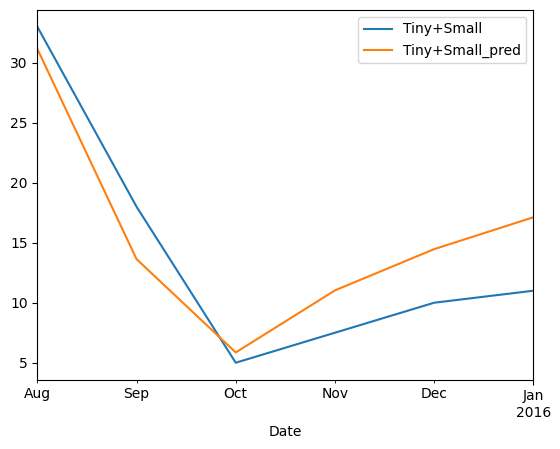

In [305]:
preds[(preds["Iter_n"] == 2) & (preds["FarmID"] == "DA5")][["Tiny+Small", "Tiny+Small_pred"]].plot()

In [269]:
preds_transformed = pd.DataFrame()
target_values = ["Tiny+Small", "Large+Mature"] + [f"{target}_pred" for target in ["Tiny+Small", "Large+Mature"]]
for i in preds["Iter_n"].unique():
    for farmid in preds["FarmID"].unique():
        temp = preds[(preds["Iter_n"] == i) & (preds["FarmID"] == farmid)]
        temp = temp.reset_index()
        temp = temp.pivot(index=["FarmID", "Iter_n"], columns='Date', values=target_values)
        temp.columns = [f"{col[0]}_+{i}" for col, i in zip(temp.columns.values, list(range(1, 7)) * 4)]
        temp = temp.reset_index()
        preds_transformed = preds_transformed.append(temp)

In [270]:
preds_transformed

,FarmID,Iter_n,Tiny+Small_+1,Tiny+Small_+2,Tiny+Small_+3,Tiny+Small_+4,Tiny+Small_+5,Tiny+Small_+6,Large+Mature_+1,Large+Mature_+2,...,Tiny+Small_pred_+3,Tiny+Small_pred_+4,Tiny+Small_pred_+5,Tiny+Small_pred_+6,Large+Mature_pred_+1,Large+Mature_pred_+2,Large+Mature_pred_+3,Large+Mature_pred_+4,Large+Mature_pred_+5,Large+Mature_pred_+6
0,AG10,1,13.500000,13.0,33.0,18.0,5.0,11.0,79.0,33.0,...,42.671882,47.977958,48.926661,47.766607,91.199115,45.619082,24.853343,16.804511,14.287147,29.105339
0,AG11,1,52.000000,70.0,70.0,74.0,11.0,66.0,76.5,62.0,...,82.218468,63.608294,49.250453,36.752490,67.593440,41.061970,26.211266,23.981851,28.569740,33.980913
0,DA4,1,5.000000,2.0,0.0,2.0,4.0,0.0,11.5,5.0,...,-2.612225,-0.589981,2.680186,6.017048,1.493913,7.969838,16.761410,20.656155,20.732866,19.698399
0,SP23,1,5.000000,6.0,21.0,14.0,16.0,71.0,14.0,0.0,...,116.503674,92.062529,94.149405,60.442840,15.357939,99.351544,20.537170,-15.138773,24.106983,33.759818
0,GA20,1,1.000000,1.0,24.0,41.0,24.0,37.0,6.0,8.0,...,48.489381,53.798197,53.977835,51.015273,15.304239,29.340335,15.393384,10.275071,15.304111,22.927054
0,GA45,1,196.375000,224.0,230.0,114.0,2.0,4.0,66.5,42.0,...,87.578186,87.578186,87.578186,87.578186,75.736770,68.445846,62.892373,58.662310,55.440284,52.986077
0,SP22,1,9.000000,15.0,29.0,2.0,1.0,14.0,6.0,4.0,...,18.247239,19.671134,21.936643,23.009865,8.038219,11.602916,14.759639,23.240087,29.770791,34.217274
0,DA5,1,8.500000,14.0,19.0,8.0,22.0,62.0,11.0,5.0,...,-7.407641,12.471442,28.027889,50.617723,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
0,AG10,2,19.000000,92.0,36.0,8.0,7.0,85.0,8.0,5.0,...,41.780962,42.681008,41.682712,40.389667,25.266122,37.037275,45.140796,47.896782,47.032718,44.976611
0,AG11,2,2.000000,19.0,23.0,10.0,11.0,97.0,46.0,8.0,...,37.885099,40.273409,39.380224,37.532801,43.465436,33.833259,41.454130,44.901995,39.387976,33.128787


In [296]:
targets_col = [f"{target}_+{i}" for target in ["Tiny+Small", "Large+Mature"] for i in list(range(1, 7))]
preds_col = [f"{target}_+{i}" for target in ["Tiny+Small_pred", "Large+Mature_pred"] for i in list(range(1, 7))]
target_scores = {"Iter_n": [], "target": [], "rmse": []}
for i in preds_transformed["Iter_n"].unique():
    for target, pred in zip(targets_col, preds_col):
        target_scores["Iter_n"].append(i)
        target_scores["target"].append(target)
        target_scores["rmse"].append(sqrt(mse(preds_transformed[preds_transformed["Iter_n"] == i][target], 
        preds_transformed[preds_transformed["Iter_n"] == i][pred])))

In [297]:
pd.DataFrame(target_scores)

,Iter_n,target,rmse
0,1,Tiny+Small_+1,38.067737
1,1,Tiny+Small_+2,52.137593
2,1,Tiny+Small_+3,62.317032
3,1,Tiny+Small_+4,32.212771
4,1,Tiny+Small_+5,47.695250
5,1,Tiny+Small_+6,34.905826
6,1,Large+Mature_+1,8.232194
7,1,Large+Mature_+2,38.460676
8,1,Large+Mature_+3,24.608848
9,1,Large+Mature_+4,24.335523


In [282]:
print(sqrt(mse(preds_transformed["Tiny+Small_+6"], preds_transformed["Tiny+Small_pred_+6"])))
print(sqrt(mse(preds_transformed["Large+Mature_+6"], preds_transformed["Large+Mature_pred_+6"])))

34.61957737310376
19.075905813252245


<Axes: >

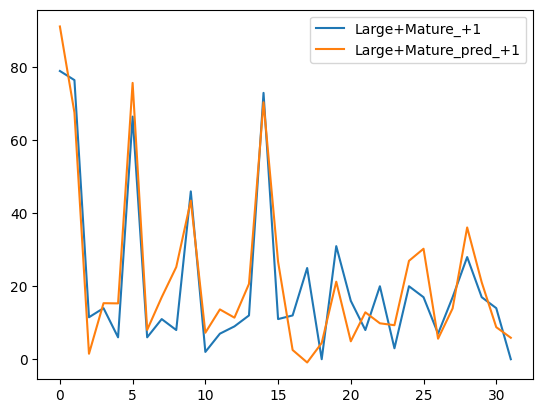

In [284]:
preds_transformed[["Large+Mature_+1", "Large+Mature_pred_+1"]].reset_index().drop(columns=["index"]).plot()